## 1.1 Introduction

**Dataset:** Customer Churn Dataset
<br>**Source:** Kaggle
<br>**Context:** This Dataset contains the financial information of an membership firm.
<br>**Objective:** Objective is to predict risk score of the member so that organization can avert the risk fafctor.


## 1.2 Preprocessing Dataset

### 1.2.1 Importing Libraries

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### 1.2.2 Reading Dataset

In [2]:
df = pd.read_parquet(r'../dataset/churn.parquet')
df.head(3)

,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,XW0DQ7H,Village,Platinum Membership,17-08-2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,5K0N3X1,City,Premium Membership,28-08-2017,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,1F2TCL3,Town,No Membership,11-11-2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1


### 1.2.3 Analyze Dataset Structure

#### 1.2.3.1 Rows & Columns

In [3]:
print(f"Dataset contains {df.shape[0]} records and {df.shape[1]} features..!!")

Dataset contains 36992 records and 23 features..!!


#### 1.2.3.2 Removing Duplicates

In [4]:
print(f"Dropping: Duplicate Records\t {df.duplicated().sum()}")
df = df.drop_duplicates()

Dropping: Duplicate Records	 0


#### 1.2.3.3 Features Statistics


In [5]:
target_feature = df['churn_risk_score']

features = ['age', 'gender', 'security_no', 'region_category',
       'membership_category', 'joining_date', 'joined_through_referral',
       'referral_id', 'preferred_offer_types', 'medium_of_operation',
       'internet_option', 'last_visit_time', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback',]

numeric_features = df[features].select_dtypes(include=np.number)
categorical_features = df[features].select_dtypes(exclude=np.number)

In [6]:
# Numeric Features Stats
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36992.0,37.118161,15.867412,10.000000,23.0000,37.000,51.000,64.000000
days_since_last_login,36992.0,-41.915576,228.819900,-999.000000,8.0000,12.000,16.000,26.000000
avg_time_spent,36992.0,243.472334,398.289149,-2814.109110,60.1025,161.765,356.515,3235.578521
avg_transaction_value,36992.0,29271.194003,19444.806226,800.460000,14177.5400,27554.485,40855.110,99914.050000
points_in_wallet,33549.0,686.882199,194.063624,-760.661236,616.1500,697.620,763.950,2069.069761


In [7]:
# Categorical Features Stats
categorical_features.describe().T

,count,unique,top,freq
gender,36992,3,F,18490
security_no,36992,36992,XW0DQ7H,1
region_category,31564,3,Town,14128
membership_category,36992,6,Basic Membership,7724
joining_date,36992,1096,02-06-2015,55
joined_through_referral,36992,3,No,15839
referral_id,36992,11359,xxxxxxxx,17846
preferred_offer_types,36704,3,Gift Vouchers/Coupons,12349
medium_of_operation,36992,4,Desktop,13913
internet_option,36992,3,Wi-Fi,12413


#### 1.3.3.4 Checking NA Values

In [8]:
# checking NA Values in numeric_cols
100*(numeric_features.isna().sum()/numeric_features.shape[0])

age                      0.000000
days_since_last_login    0.000000
avg_time_spent           0.000000
avg_transaction_value    0.000000
points_in_wallet         9.307418
dtype: float64

In [9]:
# checking NA Values in categorical_cols
100*(categorical_features.isna().sum()/categorical_features.shape[0])

gender                           0.000000
security_no                      0.000000
region_category                 14.673443
membership_category              0.000000
joining_date                     0.000000
joined_through_referral          0.000000
referral_id                      0.000000
preferred_offer_types            0.778547
medium_of_operation              0.000000
internet_option                  0.000000
last_visit_time                  0.000000
avg_frequency_login_days         0.000000
used_special_discount            0.000000
offer_application_preference     0.000000
past_complaint                   0.000000
complaint_status                 0.000000
feedback                         0.000000
dtype: float64

In [10]:
# Checking NA Values in Target feature
target_feature.isna().sum()

0

#### 1.3.3.4.1 Ploting NA Values

<Axes: >

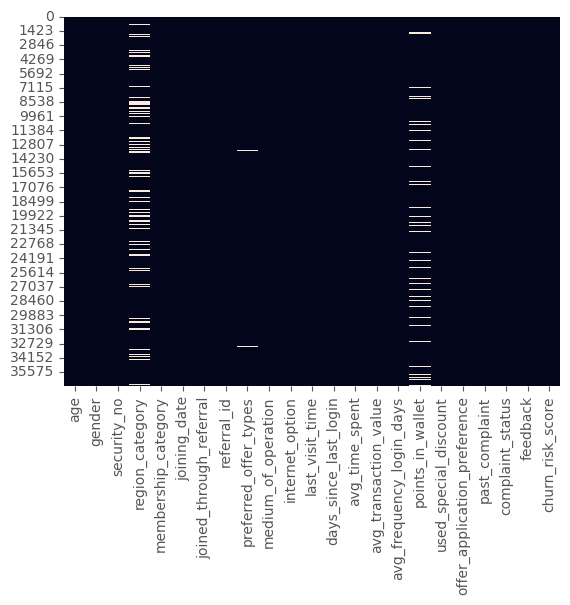

In [11]:
sns.heatmap(df.isna(), cbar = False)

**Initial Observations**<br>
- `region_category` and `points_in_wallets`has high number of null values
- `reffered_offer_types` has  less null values

- `age`: numeric col: suggests normal distribution
- `days_since_last_login`: scaler quantity: it contains -ive values
- `security_no`: identifier (must be dropped)

### 1.2.4 EDA

In [12]:
# Dropping Identifiers
df = df.drop(columns = 'security_no')

#### 1.2.4.1 Univariate Analysis

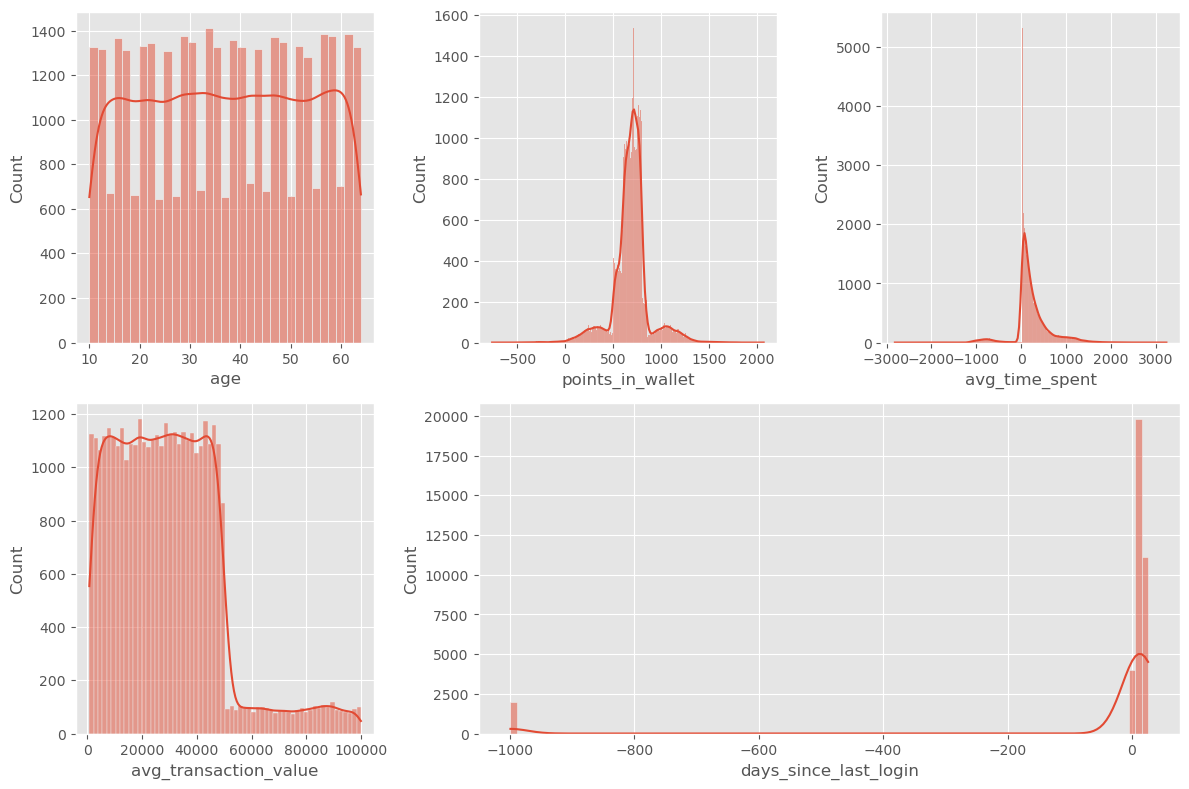

In [19]:
# Numeric Features
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(numeric_features['age'], kde = True, ax = ax1)

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(numeric_features['points_in_wallet'], kde = True, ax = ax2)

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(numeric_features['avg_time_spent'], kde = True, ax = ax3)

ax4 = fig.add_subplot(gs[1, 0])
sns.histplot(numeric_features['avg_transaction_value'], kde = True, ax = ax4)

ax5 = fig.add_subplot(gs[1, 1:])
sns.histplot(numeric_features['days_since_last_login'], bins = 100, kde = True, ax = ax5)


fig.set_tight_layout('tight')
plt.show()

In [ ]:
sns.countplot(x='churn_risk_score', data=df, orient = 'h')

plt.title('Churn_RiskScore Distribution')
plt.figure(figsize=(12, 8))
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.displot(df['age'], kde = True, )
plt.title('Age Distribution')
plt.show()

In [ ]:
sns.scatterplot(data = df, x = 'age', y = 'avg_transaction_value', hue = 'churn_risk_score')
plt.title('Distribution of Avg_transaction_value vs Age')

From the scatter plot, we can observe that higher average transaction values seem to be associated with a lower churn risk score (red points). In other words:

 - Red points (lower churn risk score) are more concentrated in the higher range of transaction values (closer to 60,000–100,000).
 - Blue points (higher churn risk score) are mostly found in the lower transaction value range (closer to 0–40,000).

This suggests that people with higher transaction values tend to have a lower likelihood of churning (churn risk score = 0), whereas those with lower transaction values are more likely to churn (churn risk score = 1).
This pattern implies that customers with higher spending might be more loyal or engaged, while those with lower spending might be at higher risk of leaving.

 - But it doesn't show strong corelation which means it also depends on other factors

In [ ]:
sns.displot(df['avg_time_spent'], kde = True)
plt.title('Distribution: Avg Time Spent')

Avg. Time Spent cannot be negative value:
 - Data Error: During record of data or system error
 - Time Diffrence Calculations: Calculating Time diffrence accross diffrent timezone may result in negative time spent

In [ ]:
import matplotlib.gridspec as gridspec


# Adding Column: Age_grp
age_grp = range(1, df.age.max())[::10]
df['age_grp'] = pd.cut(df['age'], bins = age_grp, right = False, ordered=True)

# Create subplots using GridSpec to span the KDE across both columns
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Boxplot avg_time_spent < 0
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df[df['avg_time_spent'] < 0], x='age_grp', y='avg_time_spent', ax=ax1)
ax1.set_title('avg_time_spent < 0')
ax1.tick_params(axis='x', rotation=45)

# Boxplot avg_time_spent > 0
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=df[df['avg_time_spent'] > 0], x='age_grp', y='avg_time_spent', ax=ax2)
ax2.set_title('avg_time_spent > 0')
ax2.tick_params(axis='x', rotation=45)

# Boxplot all data
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df, x='age_grp', y='avg_time_spent', ax=ax3)
ax3.set_title('All avg_time_spent')
ax3.tick_params(axis='x', rotation=45)

# Boxplot by churn risk
ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df, y='avg_time_spent', ax=ax4, hue='churn_risk_score')
ax4.set_title('avg_time_spent by churn_risk_score')

# KDE Distribution across both columns
ax5 = fig.add_subplot(gs[2, :])  # This spans all columns
sns.kdeplot(data=df, x='avg_time_spent', ax=ax5, fill=True)
ax5.set_title('KDE Distribution of avg_time_spent')

plt.tight_layout()
plt.show()

In [ ]:

plt.figure(figsize=(10, 5))

sns.kdeplot(df['avg_time_spent'], label='All', fill=True, alpha=0.3)
sns.kdeplot(df[df['avg_time_spent'] > 0]['avg_time_spent'], label='> 0', fill=True, alpha=0.3)
sns.kdeplot(df[df['avg_time_spent'] < 0]['avg_time_spent'], label='< 0', fill=True, alpha=0.3)

plt.axvline(df['avg_time_spent'].median(), color='black', linestyle='--', label='Median (All)')
plt.axvline(df[df['avg_time_spent'] > 0]['avg_time_spent'].median(), color='green', linestyle='--', label='Median (>0)')
plt.axvline(df[df['avg_time_spent'] < 0]['avg_time_spent'].median(), color='red', linestyle='--', label='Median (<0)')

plt.legend()
plt.title('KDE and Medians of avg_time_spent')
plt.show()

In [ ]:
print(f"Negative avg_time_spent: {len(df[df['avg_time_spent'] < 0]) / len(df):.1%}")
print(f"Positive avg_time_spent: {len(df[df['avg_time_spent'] > 0]) / len(df):.1%}")

In [ ]:
df[df['avg_time_spent'] < 0]['churn_risk_score'].value_counts(normalize=True)


In [ ]:
df[df['avg_time_spent'] < 0].groupby('age_grp').agg({
    'avg_time_spent': ['count', 'mean', 'max', 'min']
})

In [ ]:
df[df['avg_time_spent'] > 0].groupby('age_grp').agg({
    'avg_time_spent': ['count', 'mean', 'min', 'max']
})

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2,1, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
sns.boxenplot(data = df, x = 'membership_category', y = 'points_in_wallet', hue = 'gender', ax = ax1)

ax2 = fig.add_subplot(gs[1, 0])
sns.histplot(df['points_in_wallet'], ax = ax2, kde = True)

In [ ]:
sns.boxplot(data = df, x = 'region_category', y = 'points_in_wallet', hue = 'gender')
plt.legend()

In [ ]:
sns.countplot(data = df, x = 'region_category', hue = 'gender')

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data = df, x = 'region_category', hue = 'membership_category', hue_order = ['No Membership', 'Basic Membership', 'Silver Membership', 
                                                                                         'Gold Membership', 'Premium Membership', 'Platinum Membership'])
plt.legend()

In [ ]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 2, figure = fig, wspace=0.4, hspace=2)

# Plot: 1: Avg Time Spent accross membership category
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data = df, x = 'membership_category', y = 'avg_time_spent', 
            estimator='median', ax = ax1)
ax1.set_title('Avg Time Spent accross membership category')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

# Plot: 2 Risk Accross Membership Category
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(data = df, x = 'membership_category', y = 'avg_time_spent', 
            estimator='median', hue = 'churn_risk_score', ax = ax2)
ax2.set_title('Risk Score Accross Membership Category')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)

# Plot: 3 Distribution Plot Avg Time Spent
ax3 = fig.add_subplot(gs[1,:])
sns.histplot(data = df, x = 'avg_time_spent',  ax = ax3, kde = True)
ax3.set_title('Risk Score Accross Membership Category')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45)

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 20))
gs = gridspec.GridSpec(3, 1, figure = fig, hspace=1)

# Plot: 1: Avg Time Spent accross membership category
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data = df, x = 'membership_category', y = 'avg_transaction_value', 
            estimator='sum', ax = ax1)
ax1.set_title('Avg Time Spent accross membership category')
ax1.set_xticklabels(['Platinium Membership', 'Premium Membership', 'Gold Membership', 'Silver Membership', 'Basic Membership', 'No Membership'], rotation = 45)



# Plot: 2 Risk Accross Membership Category
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(data = df, x = 'membership_category', y = 'avg_transaction_value', 
            estimator='sum', hue = 'churn_risk_score', ax = ax2)
ax2.set_title('Risk Score Accross Membership Category')
ax2.set_xticklabels(['Platinium Membership', 'Premium Membership', 'Gold Membership', 'Silver Membership', 'Basic Membership', 'No Membership'], rotation = 45)



# Plot: 3 Distribution Plot Avg Time Spent
ax3 = fig.add_subplot(gs[2,0])
sns.histplot(data = df, x = 'avg_transaction_value',  ax = ax3, kde = True)
ax3.set_title('Risk Score Accross Membership Category')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45)

plt.show()

In [ ]:
sns.distplot(df['avg_frequency_login_days'])

In [ ]:
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].apply(lambda x: int(x) if str(x).isnumeric() else np.nan)

In [ ]:
df